### Create features without filtering things out
---

* Model Design Feedback:
    * Make the target less restrictive
        * ACH return in 3 days
        * Consider Indeterminate...this is what essentially make model look better
    * Candidates: 
        * Account balance < 0
        * Closed by risk, write off, charged off
    * Use more recent data, when Plaid is available.
        * Check availability of Plaid features
    * Drop Giact features



In [1]:
import pandas as pd
import numpy as np
import category_encoders
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%load_ext autoreload
%autoreload 2

In [2]:
transactions_df = pd.read_parquet('../../artifacts/20201005/transactions_df_unlabeled_with_tmx.parquet')

<AxesSubplot:>

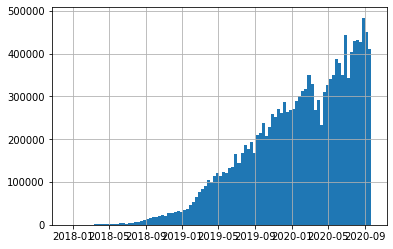

In [3]:
transactions_df.transaction_datetime.hist(bins=100)

### Build Indeterminate

In [6]:
features = ['fico_score', 
            'vantage_score', 'all7120', 'all8220', 'bcc2800', 'bcc7120', 
            'bcx3423', 'iln5520', 'iqt9413', 'iqt9415', 'mtf5820', 'stu5031', 
            'credit_card_loan_amount', 'delinquencies_90_days', 'education_loan_amount',
            'mortgage_loan_amount', 'secured_loan_amount', 'total_outstanding_balance', 
            'total_tradelines_open', 'unsecured_loan_amount', 'giact_is_pass', 
            'giact_is_decline', 'giact_is_other', 'giact_nr_pass', 'giact_nr_decline',
            'giact_nr_other', 'fraud_score_1', 'fraud_score_2', 'address_risk_score', 
            'email_risk_score', 'phone_risk_score', 'name_address_correlation', 
            'name_email_correlation', 'name_phone_correlation', 'nr_social_profiles_found', 
            'days_since_first_deposit', 'lag_acc_open_first_transaction', 'first_deposit_amount', 
            'giact_time_since_first_link', 'giact_time_since_last_link', 'transaction_as_pct_of_balance', 
            'time_since_last_transaction', 'nr_past_returns', 'nr_returns_30d', 'nr_past_deposits',
            'nr_deposits_3d', 'nr_deposits_30d', 'nr_past_transactions', 'nr_transactions_3d',
            'nr_transactions_30d', 'pct_returned_deposits', 'pct_returned_deposits_30d',
            'nr_transactions_30d_div_nr_past_transactions', 'mean_account_balance_3d',
            'mean_account_balance_30d', 'std_account_balance_3d', 'std_account_balance_30d', 
            'sum_deposits_3d', 'sum_deposits_10d', 'sum_deposits_30d', 'sum_withdrawals_3d', 
            'sum_withdrawals_10d', 'sum_withdrawals_30d', 'mean_deposits_10d', 
            'mean_deposits', 'mean_deposits_10d_div_mean_deposits', 'mean_withdrawals_10d', 
            'mean_withdrawals', 'mean_withdrawals_10d_div_mean_withdrawals', 'max_deposits_3d', 
            'max_deposits_10d', 'max_deposits_10d_div_mean_deposits',
            'max_deposits_10d_div_mean_account_balance_30d', 'max_withdrawals', 
            'max_withdrawals_3d', 'max_withdrawals_10d', 'max_withdrawals_10d_div_mean_withdrawals',
            'nr_trans_ratio', 'bal_ratio', 'deposits_ratio', 'nr_direct_deposits', 'dollar_val_dd']

def get_typed_features(df, typed):
    return list(df.columns[df.columns.str.contains(typed)])

# make sure to include plaid and quovo features
quovo_cols = get_typed_features(transactions_df, 'quovo')
plaid_cols = get_typed_features(transactions_df, 'plaid')
giact_cols = get_typed_features(transactions_df, 'giact')
tmx_cols = get_typed_features(transactions_df, 'tmx')
features = features + quovo_cols + plaid_cols + giact_cols + tmx_cols

features = sorted(list(set(features)))

# remove a lot of features
cols = transactions_df.columns[~transactions_df.columns.isin(features)]
transactions_df = transactions_df[cols]

import gc
gc.collect()

321

In [9]:
transactions_df.shape

(15295228, 69)

In [10]:
from pandas.tseries.offsets import BDay
from tqdm import tqdm

def reverse_df(df):
    """ Helper for forward looking rolling function """
    # reverse dataset
    reverse_df = df.iloc[::-1]
    ri = reverse_df.index

    # re-reverse index
    reverse_df.index = ri[0] - ri + ri[-1]

    return reverse_df

NDAYS = 90

def get_nr_returns_nd(df):
    global NDAYS
    return reverse_df(reverse_df(df).rolling(f'{NDAYS}d', min_periods=1)['is_return'].sum())

def get_bal_after_nd(df):
    global NDAYS
    return reverse_df(reverse_df(df).rolling(f'{NDAYS}d', min_periods=1)['real_ending_balance'].apply(lambda a: a[0], raw=True))

def applyParallel(dfGrouped, func):
    """ Helper to parallelize apply over groupby """
    with Pool(cpu_count()) as p:
        ret_list = p.map(func, [group for name, group in dfGrouped])
    return pd.concat(ret_list)

In [14]:
from multiprocessing import Pool, cpu_count

def get_labels_nd(df, n_days=15):
    """
    Get add labels to processed data.
    """
    # sort data for roll-ups
    global NDAYS
    NDAYS = n_days
    print(f'Ndays = {NDAYS}')
    
    # sort data for roll-ups
    
        

#     df['days_to_acc_close'] = (pd.to_datetime(df['dtc']) - df['transaction_datetime']).dt.days
    df[f'account_closed_by_risk_in_next_{n_days}d'] = df['closed_reason'].isin(['Closed by SoFi - Risk Request', 
                                                                         'Closed by SoFi - Charge-Off / Write-Off']) &\
                                               (df['days_to_acc_close'] <= n_days)
    
#     df['last_unrestricted_date_in_next_90d'] = (df['last_unrestricted_date'] - df['transaction_datetime']).dt.days.between(0, 90)
    
    # get most recent account balance
    df = pd.merge(df, 
                  df.groupby('business_account_number')['real_ending_balance'].last().rename('latest_acc_bal').reset_index(),
                  how='left', on='business_account_number')

    # does account chg/wrt off in next n days?
    df[f'is_chg_wrt_off_in_{n_days}d'] = (df['chg_wrt_off_date'] - df['transaction_datetime']).dt.days <= n_days

    # Set index to transaction datetime.
    df = df.set_index('transaction_datetime')

    df[f'bal_after_{n_days}d'] = applyParallel(df[['business_account_number', 
                                           'real_ending_balance']].groupby('business_account_number'), 
                                                     get_bal_after_nd).values
    df[f'nr_returns_in_next_{n_days}d'] = applyParallel(df[['business_account_number', 
                                                    'is_return']].groupby('business_account_number'), 
                                                 get_nr_returns_nd).values
    df = df.reset_index()
                
    # drop non check types
    
    
    def get_target(df):
        """
        """
        df[f'target_{n_days}d'] = df['is_returned'].fillna(False)
        
        df[f'indeterminate_{n_days}d'] = (df[f'target_{n_days}d'] & (df[f'bal_after_{n_days}d'] > 0)) | \
                              (~df[f'target_{n_days}d'] & (df[f'bal_after_{n_days}d'] <= 0))
        
        return df

    df = get_target(df)

    return df #.reset_index()


In [15]:
def sort_dfs(df):
    df.sort_values(by=['business_account_number', 'transaction_datetime', 'transaction_amount'], inplace=True)

In [16]:
sort_dfs(transactions_df)

for n in tqdm([10, 15, 60]):
    transactions_df = get_labels_nd(transactions_df, n_days=n)

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
  0%|          | 0/3 [00:00<?, ?it/s]

Ndays = 10


/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 33%|███▎      | 1/3 [03:39<07:19, 219.91s/it]

Ndays = 15


 67%|██████▋   | 2/3 [07:20<03:40, 220.11s/it]

Ndays = 60


100%|██████████| 3/3 [10:59<00:00, 219.96s/it]


In [17]:
transactions_df.to_parquet('../../artifacts/20201005/transactions_df_w_indeterminate.parquet')

### Check behavior

In [18]:
transactions_df.columns[(transactions_df.columns.str.contains('target') |
                        (transactions_df.columns.str.contains('indeterminate')))]

Index(['target_10d', 'indeterminate_10d', 'target_15d', 'indeterminate_15d',
       'target_60d', 'indeterminate_60d'],
      dtype='object')

In [19]:
transactions_df.shape, transactions_df.target_60d.value_counts()

((15295228, 90), False    15252339
 True        42889
 Name: target_60d, dtype: int64)

### Drop non ACH
---

In [ ]:
transactions_df = pd.read_parquet('../../artifacts/20201005/transactions_df_w_indeterminate.parquet')

In [20]:
# drop non ACH types
def drop_non_ach(df):
    df = df[df['transaction_code'].isin(['ACHDD']) & (df['transaction_amount'] > 0)]
    return df

In [21]:
transactions_df = drop_non_ach(transactions_df)

In [22]:
transactions_df.shape, transactions_df.target_60d.value_counts()

((664067, 90), False    644290
 True      19777
 Name: target_60d, dtype: int64)

### Train and OOT dev
---

In [68]:
modeling_df = transactions_df[transactions_df["transaction_datetime"].between(pd.to_datetime('2020-05-01'),
                                                    pd.to_datetime('2020-07-31'))]
test_df = transactions_df[transactions_df["transaction_datetime"] > pd.to_datetime('2020-08-01')]

In [69]:
modeling_df.shape,  test_df.shape

((112599, 90), (88890, 90))

In [70]:
modeling_df.target_60d.value_counts()

False    108825
True       3774
Name: target_60d, dtype: int64

In [29]:
n_remain = len(modeling_df)
label_counts = modeling_df.target_60d.value_counts()
n_good = label_counts.loc[False]
n_bad = label_counts.loc[True]

In [30]:
n_remain, n_good, n_bad

(3346012, 3342438, 3574)

In [31]:
test_df.target_60d.value_counts()

False    2244995
True        8731
Name: target_60d, dtype: int64

### Drop indeterminate criterias one by one
---

In [32]:
# target definitions
# df[f'is_chg_wrt_off_in_60d'] 
# df[f'account_closed_by_risk_in_next_60d'] 
# (df[f'nr_returns_in_next_60d'] > 0) 
# (df[f'bal_after_60d'] < 0)

In [33]:
# indeterminate definitions
# (df[f'target_60d'] & (df[f'bal_after_60d'] > 0)) 
# (~df[f'target_60d'] & (df[f'bal_after_60d'] <= 0))

In [44]:
def drop_bad_but_pos_balance(df):
    return df[~(df[f'target_10d'] & (df[f'bal_after_10d'] > 0))]

In [45]:
modeling_df = drop_bad_but_pos_balance(modeling_df)
n_excluded = n_remain - len(modeling_df)
n_remain = len(modeling_df)
label_counts = modeling_df.target_60d.value_counts()
n_good = label_counts.loc[False]
n_bad = label_counts.loc[True]
print(f'{n_excluded}, {n_remain}, {n_good}, {n_bad}')

0, 3304682, 3301108, 3574


In [46]:
def drop_good_but_has_returns(df):
    condition = (~df['target_10d'] & (df[f'nr_returns_in_next_10d'] > 0))
    return df[~condition]

In [47]:
modeling_df = drop_good_but_has_returns(modeling_df)
n_excluded = n_remain - len(modeling_df)
n_remain = len(modeling_df)
label_counts = modeling_df.target_60d.value_counts()
n_good = label_counts.loc[False]
n_bad = label_counts.loc[True]
print(f'{n_excluded}, {n_remain}, {n_good}, {n_bad}')

0, 3304682, 3301108, 3574


In [38]:
def drop_good_but_chg_wrt_off(df):
    return df[~(df[f'is_chg_wrt_off_in_10d'] & ~df['target_10d'])]

In [39]:
modeling_df = drop_good_but_chg_wrt_off(modeling_df)
n_excluded = n_remain - len(modeling_df)
n_remain = len(modeling_df)
label_counts = modeling_df.target_60d.value_counts()
n_good = label_counts.loc[False]
n_bad = label_counts.loc[True]
print(f'{n_excluded}, {n_remain}, {n_good}, {n_bad}')

525, 3326082, 3322508, 3574


In [40]:
def drop_good_but_neg_balance(df):
    return df[~(~df['target_10d'] & (df[f'bal_after_10d'] < 0))]

In [41]:
modeling_df = drop_good_but_neg_balance(modeling_df)
n_excluded = n_remain - len(modeling_df)
n_remain = len(modeling_df)
label_counts = modeling_df.target_60d.value_counts()
n_good = label_counts.loc[False]
n_bad = label_counts.loc[True]
print(f'{n_excluded}, {n_remain}, {n_good}, {n_bad}')

20388, 3305694, 3302120, 3574


In [42]:
def drop_good_but_closed_by_risk(df):
    condition = (~df['target_10d'] & df[f'account_closed_by_risk_in_next_10d'])
    return df[~condition]

In [43]:
fn = drop_good_but_closed_by_risk
modeling_df = fn(modeling_df)
n_excluded = n_remain - len(modeling_df)
n_remain = len(modeling_df)
label_counts = modeling_df.target_60d.value_counts()
n_good = label_counts.loc[False]
n_bad = label_counts.loc[True]
print(f'{fn.__name__}: {n_excluded}, {n_remain}, {n_good}, {n_bad}')

drop_good_but_closed_by_risk: 1012, 3304682, 3301108, 3574


### Class Object

In [ ]:
transactions_df = pd.read_parquet('../../artifacts/20201005/transactions_df_w_indeterminate.parquet')

In [186]:
import gc

class DataWaterfallReport:
    
    def __init__(self, df, function_sequence, 
                 col_to_expand=None, dropna=False,
                 index_formatter=None, column_formatter=None):
        """
        generate data waterfall for binary classification task
        
        @params df: dataframe 
                    - df of starting population
        @params function_sequence: list of functions
                    - each function takes in single argument: df
                      and returns a single df with remaining rows for next round
                    - Note: function name will be used as report index
        @params col_to_expand: str 
                    - categorical columns to expend into columns
                    - with each column recording a count for each categorical value
        @params dropna: bool
                    - whether to count NaN
        @params inplace: bool
                    - df will be modified if inplace=True, will save memory
        """
        
        self.df = df
        self.functions = function_sequence
        self.col_to_expand = col_to_expand
        if col_to_expand is not None:
            col_order = df[col_to_expand].value_counts(dropna=dropna)
            col_order = col_order.index.to_list()
        else:
            col_order = []
        self.dropna = dropna

        # reporting data
        # dictionary: 
        # key - function
        # values - (#excluded, #remaining, #good, #bad)
        self.record_index = []
        self.record_cols = ['Excluded', 'Remain'] + col_order
        self.record = []  
        self.waterfall = None
        
        # formatting
        if index_formatter is None:
            self.index_formatter = self.default_index_formatter
        else:
            self.index_formatter = index_formatter
            
        if column_formatter is None:
            self.column_formatter = self.default_column_formatter
        else:
            self.column_formatter = column_formatter   
                
    
    def default_column_formatter(self, col_name):
        return f'# {col_name}'
    
    
    def default_index_formatter(self, index):
        return ' '.join(index.split('_')).title()
    
    
    def format_report(self, records, index, columns, 
                      index_formatter, column_formatter, present_ready):
        
        record_index = [index_formatter(idx) for idx in index]
        record_cols = [column_formatter(col) for col in columns]
        
        if present_ready:
            # convert every cell to string format
            records_ = []
            for row in range(len(records)):
                record_ = []
                for col in range(len(records[0])):
                    elem = records[row][col]
                    record_.append('' if pd.isna(elem) else int(elem))
                records_.append(record_)
            records = records_
            
        result = pd.DataFrame(records, 
                              index=record_index,
                              columns=record_cols)
            
        return result
    
    
    def get_report(self, present_ready=False):
        
        df = self.df.copy()
        
        col2xp = self.col_to_expand
        dropna = self.dropna
        
        # starter row
        row = []
        n_excluded = None
        n_remain = len(df)
        row.extend([n_excluded, n_remain])
        
        if col2xp is not None:
            row.extend(df[col2xp].value_counts(dropna=dropna).values.tolist())
        
        record_index = ["Starting Population"]
        records = [row]
        
        for fn in self.functions:
            row = []
            
            # build another row
            record_index.append(fn.__name__)
            df = fn(df)
            n_excluded = n_remain - len(df)
            n_remain = len(df)
            row.extend([n_excluded, n_remain])
            
            if col2xp is not None:
                row.extend(df[col2xp].value_counts(
                    dropna=dropna).values.tolist())
            
            records.append(row)
        
        self.record_index = record_index
        self.records = records
        
        self.waterfall = self.format_report(records, record_index,
                                            self.record_cols,
                                            self.index_formatter,
                                            self.column_formatter,
                                            present_ready)
        
        return self.waterfall
            

In [156]:
modeling_df = transactions_df[transactions_df["transaction_datetime"].between(pd.to_datetime('2020-05-01'),
                                                    pd.to_datetime('2020-07-31'))]
test_df = transactions_df[transactions_df["transaction_datetime"] > pd.to_datetime('2020-08-01')]

In [195]:
modeling_df.to_parquet('../../../../rdsutils/examples/artifact/ach_modeling_data.parquet')

In [187]:
# drop non ACH types
def drop_non_ach(df):
    df = df[df['transaction_code'].isin(['ACHDD']) & (df['transaction_amount'] > 0)]
    return df

def drop_bad_but_pos_balance(df):
    return df[~(df[f'target_10d'] & (df[f'bal_after_10d'] > 0))]

def drop_good_but_has_returns(df):
    condition = (~df['target_10d'] & (df[f'nr_returns_in_next_10d'] > 0))
    return df[~condition]

def drop_good_but_chg_wrt_off(df):
    return df[~(df[f'target_10d'] & ~df['target_10d'])]

def drop_good_but_neg_balance(df):
    return df[~(~df['target_10d'] & (df[f'bal_after_10d'] < 0))]

def drop_good_but_closed_by_risk(df):
    condition = (~df['target_10d'] & df[f'account_closed_by_risk_in_next_10d'])
    return df[~condition]

In [192]:
fns = [drop_non_ach,
       drop_bad_but_pos_balance, 
       drop_good_but_has_returns,
       drop_good_but_chg_wrt_off,
       drop_good_but_neg_balance,
       drop_good_but_closed_by_risk]
wf = DataWaterfallReport(modeling_df, fns, 'target_10d')

In [193]:
waterfall = wf.get_report(False)
waterfall

,# Excluded,# Remain,# False,# True
Starting Population,NaN,3349862,3342438,7424
Drop Non Ach,3237263.0,112599,108825,3774
Drop Bad But Pos Balance,1961.0,110638,108825,1813
Drop Good But Has Returns,667.0,109971,108158,1813
Drop Good But Chg Wrt Off,0.0,109971,108158,1813
Drop Good But Neg Balance,74.0,109897,108084,1813
Drop Good But Closed By Risk,11.0,109886,108073,1813


In [194]:
waterfall = wf.get_report(True)
waterfall

,# Excluded,# Remain,# False,# True
Starting Population,,3349862,3342438,7424
Drop Non Ach,3237263,112599,108825,3774
Drop Bad But Pos Balance,1961,110638,108825,1813
Drop Good But Has Returns,667,109971,108158,1813
Drop Good But Chg Wrt Off,0,109971,108158,1813
Drop Good But Neg Balance,74,109897,108084,1813
Drop Good But Closed By Risk,11,109886,108073,1813
